In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import umap
import hdbscan
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from sklearn.preprocessing import normalize


In [ ]:
# def standardize_embeddings_array(emb_array: np.ndarray) -> np.ndarray:
#     """
#     Standardize a 2D array of embeddings (mean=0, std=1 per column).
#     """
#     mean = np.mean(emb_array, axis=0)
#     std = np.std(emb_array, axis=0)
#     std[std == 0] = 1e-8  # Prevent divide-by-zero
#     return (emb_array - mean) / std

# df = pd.read_json("results/task2/task2_data.json", lines=True)
# # --- Step 1: Expand lists to 2D arrays ---
# ref_array = np.vstack(df["ref_embeddings"].to_numpy())
# gen_array = np.vstack(df["gen_embeddings"].to_numpy())

# # --- Step 2: Standardize ---
# ref_std = standardize_embeddings_array(ref_array)
# gen_std = standardize_embeddings_array(gen_array)

# # --- Step 3: Store back in DataFrame ---
# df["ref_std"] = list(ref_std)
# df["gen_std"] = list(gen_std)

# zone_path = "datasets/job_zone.xlsx"
# zone = pd.read_excel(zone_path)
# zone = zone[['Title', 'Job Zone']]
# zone.columns = ['title', 'zone']
# df = df.merge(zone, left_on='title', right_on='title', how='left')
# df_std = df.copy()
# df_std = df_std.drop(columns=["ref_embeddings", "gen_embeddings"])
# df_std["cos_sim_std"] = [
#     cosine_similarity([r], [g])[0][0]
#     for r, g in zip(df_std["ref_std"], df_std["gen_std"])
# ]
# df_std["industry"] = df_std["code"].apply(lambda x: x.split("-")[0])
# df_std["industry"] = df_std["industry"].astype("category")
# df_std["code"] = df_std["code"].astype("category")
# df_std["zone"] = df_std["zone"].astype("category")
# df_std = df_std.drop(columns=["ref_std", "gen_std"])

# df_std.to_json(
#     "results/task2/task2_data_std.json",
#     lines=True,
#     orient="records",
#     force_ascii=False,
#     index=False,
# )

### Regression

In [69]:
df = pd.read_json("results/task2/task2_data_std.json", lines=True)
#change values of "model", llama 70b to "llama-70b"
df["model"] = df["model"].replace("llama 70b", "llama70b")
df["model"] = df["model"].replace("llama 3b", "llama 3b")
df["model"] = df["model"].apply(lambda x: x.split(" ")[0] if " " in x else x)
df_model = df[df["model"] == "mistral"].copy()
df_model

,title,code,iteration,model,prompt,zone,cos_sim_std,industry
52740,"Potters, Manufacturing",51-9195.05,8,mistral,benchmark,3,0.801784,51
52741,"Pourers and Casters, Metal",51-4052.00,8,mistral,benchmark,2,0.758061,51
52742,Power Distributors and Dispatchers,51-8012.00,8,mistral,benchmark,3,0.803365,51
52743,Power Plant Operators,51-8013.00,8,mistral,benchmark,2,0.660010,51
52744,Precision Agriculture Technicians,19-4012.01,8,mistral,benchmark,3,0.883189,19
...,...,...,...,...,...,...,...,...
70315,Information Security Analysts,15-1212.00,2,mistral,persona,4,0.698968,15
70316,Information Technology Project Managers,15-1299.09,2,mistral,persona,4,0.858831,15
70317,"Inspectors, Testers, Sorters, Samplers, and We...",51-9061.00,2,mistral,persona,2,0.522595,51
70318,Instructional Coordinators,25-9031.00,2,mistral,persona,5,0.779383,25


Calculating average cosine similarity per job per prompt...
Difference scores calculated.
         code  avg_cos_sim_benchmark  avg_cos_sim_persona  diff_cos_sim
0  11-1011.00               0.725288             0.717413     -0.007875
1  11-1011.03               0.774074             0.768980     -0.005094
2  11-1021.00               0.628124             0.630712      0.002588
3  11-2011.00               0.837551             0.851093      0.013542
4  11-2021.00               0.772825             0.777128      0.004303
Overall average difference score: -0.0033

Average difference score by industry:
industry
11   -0.001783
13    0.002945
15   -0.001667
17    0.001992
19   -0.003591
21   -0.001332
23   -0.006752
25   -0.017650
27   -0.003330
29    0.000943
31    0.004670
33   -0.006423
35    0.000137
37   -0.001208
39    0.000057
41   -0.006542
43   -0.001312
45    0.000072
47   -0.008268
49   -0.003797
51   -0.004467
53   -0.004735
Name: diff_cos_sim, dtype: float64

Industry with average 

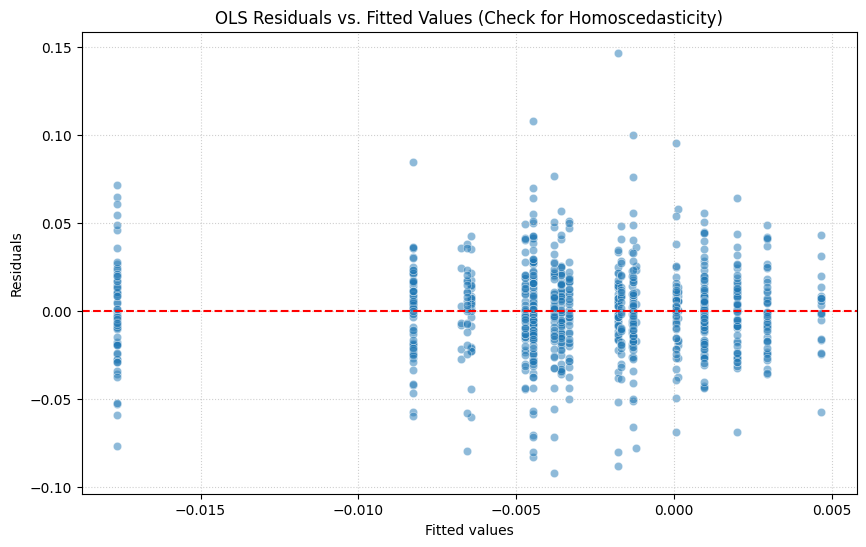

Interpretation of Residuals vs. Fitted Values Plot (OLS):
- Look for a random scatter of points around the horizontal red line (y=0).
- If the spread of residuals changes across different fitted values (which correspond to different industry group means), it suggests heteroscedasticity (non-constant variance).
------------------------------


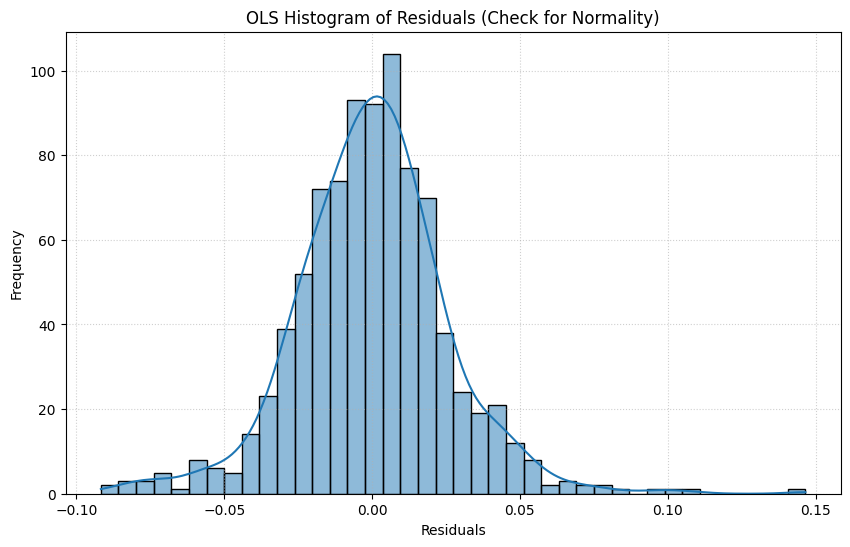

Interpretation of Histogram of Residuals Plot (OLS):
- The histogram should ideally look like a bell curve (normal distribution).
- Significant deviations suggest non-normality.
------------------------------


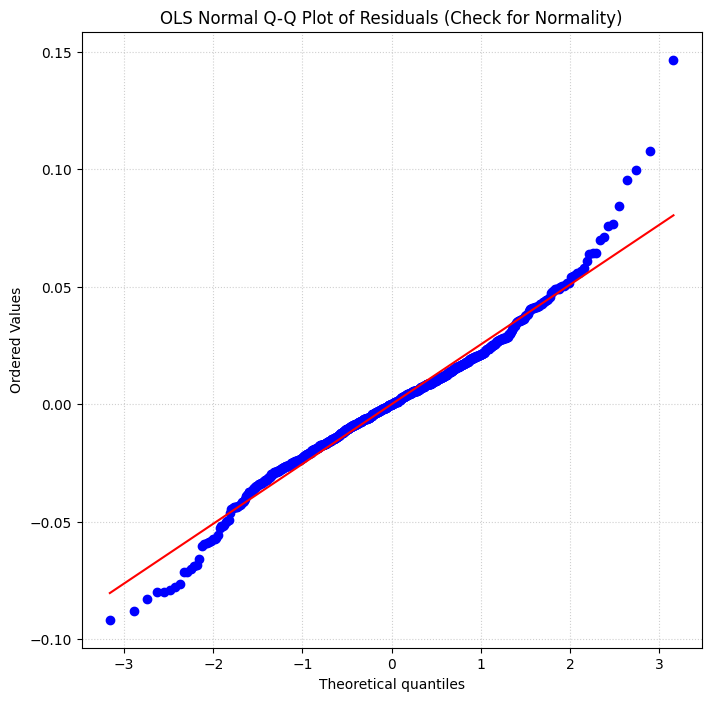

Interpretation of Normal Q-Q Plot of Residuals (OLS):
- The points should ideally fall along the straight diagonal line.
- Deviations indicate departures from normality.
------------------------------


In [70]:
# --- 1. Calculate Average Cosine Similarity per Job per Prompt ---

print("Calculating average cosine similarity per job per prompt...")

# Group by Job ID ('code') and Prompt Type ('prompt') and calculate the mean cosine similarity
avg_cos_sim = df_model.groupby(['code', 'prompt'])['cos_sim_std'].mean().reset_index()

# Pivot the table to have benchmark and persona means in separate columns for each job
avg_cos_sim_pivot = avg_cos_sim.pivot(index='code', columns='prompt', values='cos_sim_std').reset_index()

# Rename columns for clarity
avg_cos_sim_pivot.columns.name = None
avg_cos_sim_pivot = avg_cos_sim_pivot.rename(columns={'benchmark': 'avg_cos_sim_benchmark', 'persona': 'avg_cos_sim_persona'})

# --- 2. Calculate the Difference Score per Job ---

avg_cos_sim_pivot['diff_cos_sim'] = avg_cos_sim_pivot['avg_cos_sim_persona'] - avg_cos_sim_pivot['avg_cos_sim_benchmark']

print("Difference scores calculated.")
print(avg_cos_sim_pivot.head())

# --- Get Industry information for each job ---
# We need the industry for each job to use it as a predictor.
# We can get this from the original df_model, making sure to get a unique industry for each code.
job_industry_map = df_model[['code', 'industry']].drop_duplicates().set_index('code')

# Merge the difference scores with the industry information
df_diff = avg_cos_sim_pivot.set_index('code').join(job_industry_map).reset_index()

# Ensure industry is treated as a categorical variable
df_diff['industry'] = df_diff['industry'].astype('category')


# --- 3. Fit a Standard Linear Regression Model on the Difference Score ---
df_diff['industry'] = df_diff['industry'].astype(str)

# Calculate the overall average difference score
overall_avg_diff = df_diff['diff_cos_sim'].mean()
print(f"Overall average difference score: {overall_avg_diff:.4f}")

# Calculate the average difference score for each industry
industry_avg_diff = df_diff.groupby('industry')['diff_cos_sim'].mean()
print("\nAverage difference score by industry:")
print(industry_avg_diff)

# Find the industry whose average is closest to the overall average
# Calculate the absolute difference between each industry average and the overall average
diff_from_overall_avg = (industry_avg_diff - overall_avg_diff).abs()

# Find the industry with the minimum absolute difference
reference_industry_code = diff_from_overall_avg.idxmin()
print(f"\nIndustry with average closest to overall average: {reference_industry_code}")


print(f"\nRe-fitting OLS Regression with Industry {reference_industry_code} explicitly set as the reference...")
try:
    # Model formula using an f-string to insert the reference_industry_code
    # The variable {reference_industry_code} is inserted into the string.
    # Double quotes around the variable inside the Treatment() call are part of the Patsy syntax
    formula_string = f'diff_cos_sim ~ C(industry, Treatment(reference="{reference_industry_code}"))'
    print(f"Using formula: {formula_string}")

    ols_model_fit = smf.ols(
        formula_string, # Use the dynamically created formula string
        data=df_diff
    ).fit()

    print("\nOLS Regression Results (Explicit Reference Set):")
    print(ols_model_fit.summary())

    # --- 4. Check Assumptions of the Linear Regression Model ---

    print("\nGenerating assumption check plots for Linear Regression on difference scores...")

    # Fitted values from the OLS model
    ols_fitted_values = ols_model_fit.fittedvalues

    # Residuals from the OLS model
    ols_residuals = ols_model_fit.resid

    # Plot 1: Residuals vs. Fitted Values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=ols_fitted_values, y=ols_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("OLS Residuals vs. Fitted Values (Check for Homoscedasticity)")
    # Linearity is less relevant with categorical predictors for OLS assumptions plots in this form
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Residuals vs. Fitted Values Plot (OLS):")
    print("- Look for a random scatter of points around the horizontal red line (y=0).")
    print("- If the spread of residuals changes across different fitted values (which correspond to different industry group means), it suggests heteroscedasticity (non-constant variance).")
    print("-" * 30)

    # Plot 2: Histogram of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(ols_residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("OLS Histogram of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Histogram of Residuals Plot (OLS):")
    print("- The histogram should ideally look like a bell curve (normal distribution).")
    print("- Significant deviations suggest non-normality.")
    print("-" * 30)

    # Plot 3: Normal Q-Q Plot of Residuals
    plt.figure(figsize=(8, 8))
    stats.probplot(ols_residuals, dist="norm", plot=plt)
    plt.title("OLS Normal Q-Q Plot of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()#+
    #
    print("Interpretation of Normal Q-Q Plot of Residuals (OLS):")
    print("- The points should ideally fall along the straight diagonal line.")
    print("- Deviations indicate departures from normality.")
    print("-" * 30)

except Exception as e:
    print(f"\nAn error occurred during analysis: {e}")
    print("Please ensure statsmodels, pandas, matplotlib, seaborn, and scipy are installed.")
    print("Check column names and data structure.")

Overall average difference score: -0.0033

Average difference score by zone:
zone
1   -0.000716
2   -0.003713
3   -0.003562
4   -0.000652
5   -0.006447
Name: diff_cos_sim, dtype: float64

zone with average closest to overall average: 3

Re-fitting OLS Regression with zone 3 explicitly set as the reference...
Using formula: diff_cos_sim ~ C(zone, Treatment(reference="3"))

OLS Regression Results (Explicit Reference Set):
                            OLS Regression Results                            
Dep. Variable:           diff_cos_sim   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.162
Date:                Mon, 19 May 2025   Prob (F-statistic):              0.326
Time:                        16:46:55   Log-Likelihood:                 1957.3
No. Observations:                 879   AIC:                            -3905.
Df Residuals:          

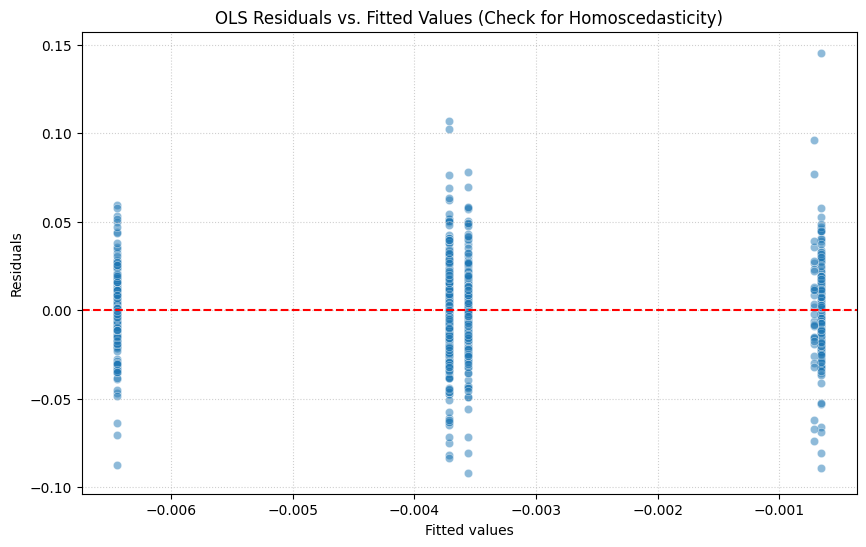

Interpretation of Residuals vs. Fitted Values Plot (OLS):
- Look for a random scatter of points around the horizontal red line (y=0).
- If the spread of residuals changes across different fitted values (which correspond to different zone group means), it suggests heteroscedasticity (non-constant variance).
------------------------------


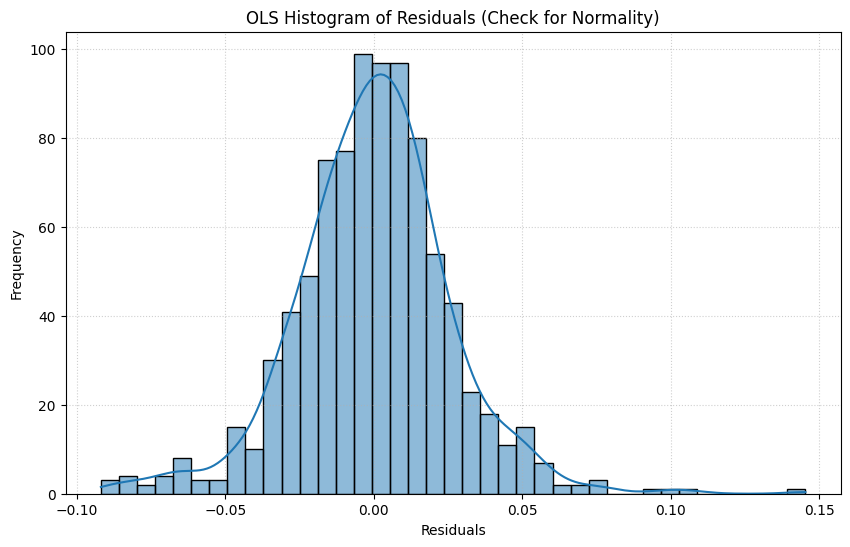

Interpretation of Histogram of Residuals Plot (OLS):
- The histogram should ideally look like a bell curve (normal distribution).
- Significant deviations suggest non-normality.
------------------------------


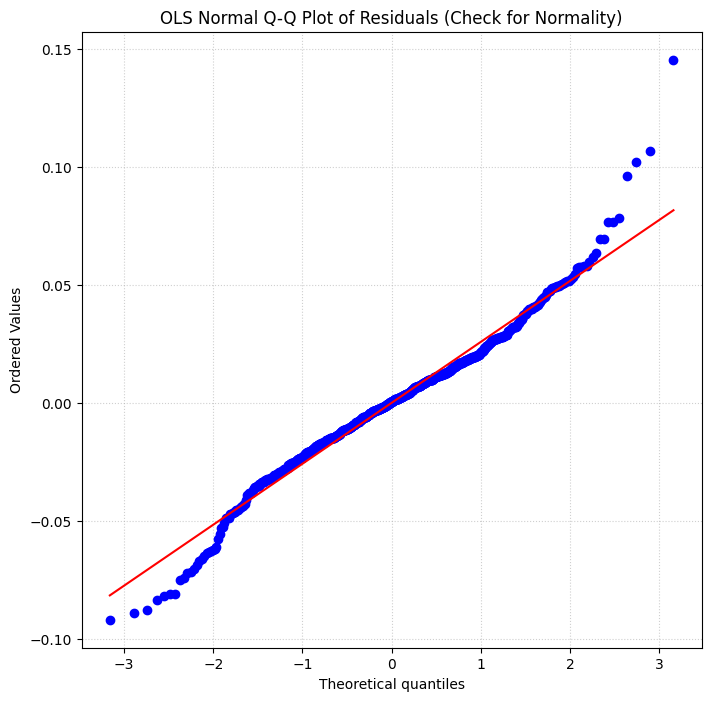

Interpretation of Normal Q-Q Plot of Residuals (OLS):
- The points should ideally fall along the straight diagonal line.
- Deviations indicate departures from normality.
------------------------------


In [71]:
# --- Get zone information for each job ---
# We need the zone for each job to use it as a predictor.
# We can get this from the original df_model, making sure to get a unique zone for each code.
job_zone_map = df_model[['code', 'zone']].drop_duplicates().set_index('code')

# Merge the difference scores with the zone information
df_diff = avg_cos_sim_pivot.set_index('code').join(job_zone_map).reset_index()

# Ensure zone is treated as a categorical variable
df_diff['zone'] = df_diff['zone'].astype('category')


# --- 3. Fit a Standard Linear Regression Model on the Difference Score ---
df_diff['zone'] = df_diff['zone'].astype(str)

# Calculate the overall average difference score
overall_avg_diff = df_diff['diff_cos_sim'].mean()
print(f"Overall average difference score: {overall_avg_diff:.4f}")

# Calculate the average difference score for each zone
zone_avg_diff = df_diff.groupby('zone')['diff_cos_sim'].mean()
print("\nAverage difference score by zone:")
print(zone_avg_diff)

# Find the zone whose average is closest to the overall average
# Calculate the absolute difference between each zone average and the overall average
diff_from_overall_avg = (zone_avg_diff - overall_avg_diff).abs()

# Find the zone with the minimum absolute difference
reference_zone_code = diff_from_overall_avg.idxmin()
print(f"\nzone with average closest to overall average: {reference_zone_code}")


print(f"\nRe-fitting OLS Regression with zone {reference_zone_code} explicitly set as the reference...")
try:
    # Model formula using an f-string to insert the reference_zone_code
    # The variable {reference_zone_code} is inserted into the string.
    # Double quotes around the variable inside the Treatment() call are part of the Patsy syntax
    formula_string = f'diff_cos_sim ~ C(zone, Treatment(reference="{reference_zone_code}"))'
    print(f"Using formula: {formula_string}")

    ols_model_fit = smf.ols(
        formula_string, # Use the dynamically created formula string
        data=df_diff
    ).fit()

    print("\nOLS Regression Results (Explicit Reference Set):")
    print(ols_model_fit.summary())

    # --- 4. Check Assumptions of the Linear Regression Model ---

    print("\nGenerating assumption check plots for Linear Regression on difference scores...")

    # Fitted values from the OLS model
    ols_fitted_values = ols_model_fit.fittedvalues

    # Residuals from the OLS model
    ols_residuals = ols_model_fit.resid

    # Plot 1: Residuals vs. Fitted Values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=ols_fitted_values, y=ols_residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title("OLS Residuals vs. Fitted Values (Check for Homoscedasticity)")
    # Linearity is less relevant with categorical predictors for OLS assumptions plots in this form
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Residuals vs. Fitted Values Plot (OLS):")
    print("- Look for a random scatter of points around the horizontal red line (y=0).")
    print("- If the spread of residuals changes across different fitted values (which correspond to different zone group means), it suggests heteroscedasticity (non-constant variance).")
    print("-" * 30)

    # Plot 2: Histogram of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(ols_residuals, kde=True)
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.title("OLS Histogram of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()
    print("Interpretation of Histogram of Residuals Plot (OLS):")
    print("- The histogram should ideally look like a bell curve (normal distribution).")
    print("- Significant deviations suggest non-normality.")
    print("-" * 30)

    # Plot 3: Normal Q-Q Plot of Residuals
    plt.figure(figsize=(8, 8))
    stats.probplot(ols_residuals, dist="norm", plot=plt)
    plt.title("OLS Normal Q-Q Plot of Residuals (Check for Normality)")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()#+
    #
    print("Interpretation of Normal Q-Q Plot of Residuals (OLS):")
    print("- The points should ideally fall along the straight diagonal line.")
    print("- Deviations indicate departures from normality.")
    print("-" * 30)

except Exception as e:
    print(f"\nAn error occurred during analysis: {e}")
    print("Please ensure statsmodels, pandas, matplotlib, seaborn, and scipy are installed.")
    print("Check column names and data structure.")

In [99]:
df

,title,code,iteration,ref_embeddings,gen_embeddings,model,prompt,zone,industry
0,Accountants and Auditors,13-2011.00,0,"[0.057781610600000005, 0.0170972049, 0.0063463...","[0.0417524837, 0.0190687012, -0.00704117400000...",deepseek-r1,benchmark,4,13
1,Actors,27-2011.00,0,"[0.0500539839, -0.0298149604, 0.0063925134, -0...","[0.002087527, -0.0311016198, -0.0193263888, -0...",deepseek-r1,benchmark,2,27
2,Actuaries,15-2011.00,0,"[0.0549289249, 0.0150179062, -0.016457418, -0....","[-0.040955919800000004, 0.0421547741, -0.02783...",deepseek-r1,benchmark,4,15
3,Acupuncturists,29-1291.00,0,"[0.0539231524, -0.0455680303, 0.0001075003, -0...","[0.0418119878, -0.0549953133, -0.0264714062000...",deepseek-r1,benchmark,5,29
4,Acute Care Nurses,29-1141.01,0,"[0.0543873385, -0.061012145100000005, -0.00616...","[0.0588279627, -0.0555830337, -0.0179473888000...",deepseek-r1,benchmark,3,29
...,...,...,...,...,...,...,...,...,...
70315,Information Security Analysts,15-1212.00,2,"[0.057768281500000004, 0.0274809953, -0.012417...","[0.0343777537, 0.044208828400000004, -2.05231e...",mistral,persona,4,15
70316,Information Technology Project Managers,15-1299.09,2,"[0.0582552738, -0.025281094, -0.02123377100000...","[0.0510931164, 0.0046637557, -0.02471387390000...",mistral,persona,4,15
70317,"Inspectors, Testers, Sorters, Samplers, and We...",51-9061.00,2,"[-0.014055796, -0.0299870949, -0.0098509695, -...","[0.013496476200000001, -0.028076298500000003, ...",mistral,persona,2,51
70318,Instructional Coordinators,25-9031.00,2,"[0.07710634920000001, -0.0424890332, -0.007097...","[0.0882729292, -0.039919771300000004, -0.03364...",mistral,persona,5,25


### Comparing pairwise cosine distance

In [97]:
df = pd.read_json("results/task2/task2_data.json", lines=True)
# --- Step 1: Expand lists to 2D arrays ---
ref_array = np.vstack(df["ref_embeddings"].to_numpy())
gen_array = np.vstack(df["gen_embeddings"].to_numpy())

zone_path = "datasets/job_zone.xlsx"
zone = pd.read_excel(zone_path)
zone = zone[['Title', 'Job Zone']]
zone.columns = ['title', 'zone']
df = df.merge(zone, left_on='title', right_on='title', how='left')
df["industry"] = df["code"].apply(lambda x: x.split("-")[0])
df["industry"] = df["industry"].astype("category")
df["code"] = df["code"].astype("category")
df["zone"] = df["zone"].astype("category")
df["model"] = df["model"].replace("llama 70b", "llama70b")
df["model"] = df["model"].replace("llama 3b", "llama 3b")
df["model"] = df["model"].apply(lambda x: x.split(" ")[0] if " " in x else x)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, wilcoxon  # Or spearmanr for non-parametric correlation

df_dis = df[df["model"] == "mistral"].copy()
# --- 1. Average the 10 embeddings of each job for Persona and Benchmark ---

# Get unique job codes
unique_codes = df_dis['code'].unique()

# Initialize dictionaries to store average embeddings and single ref embeddings
ref_embeddings_dict = {}
avg_bench_embeddings_dict = {}
avg_pers_embeddings_dict = {}

for code in unique_codes:
    job_df_dis = df_dis[df_dis['code'] == code]
    
    # Reference embeddings (should be the same for all rows of a job, pick one)
    # Ensure it's unique per code, not per row.
    # We take the mean across all occurrences of ref_embeddings for a job, just to be safe.
    ref_embeddings_dict[code] = np.mean(
        np.stack(job_df_dis['ref_embeddings'].values), axis=0
    )

    # Average Benchmark embeddings for this job
    bench_embeddings = np.stack(job_df_dis[job_df_dis['prompt'] == 'benchmark']['gen_embeddings'].values)
    avg_bench_embeddings_dict[code] = np.mean(bench_embeddings, axis=0)

    # Average Persona embeddings for this job
    pers_embeddings = np.stack(job_df_dis[job_df_dis['prompt'] == 'persona']['gen_embeddings'].values)
    avg_pers_embeddings_dict[code] = np.mean(pers_embeddings, axis=0)

# Convert dictionaries to ordered lists of arrays
ref_embs_list = np.array([ref_embeddings_dict[code] for code in unique_codes])
avg_bench_embs_list = np.array([avg_bench_embeddings_dict[code] for code in unique_codes])
avg_pers_embs_list = np.array([avg_pers_embeddings_dict[code] for code in unique_codes])

print(f"Shape of ref_embs_list: {ref_embs_list.shape}")
print(f"Shape of avg_bench_embs_list: {avg_bench_embs_list.shape}")
print(f"Shape of avg_pers_embs_list: {avg_pers_embs_list.shape}")
print("-" * 30)

# --- 2. L2 normalize each of the embeddings ---
# Normalize ensures that vector magnitudes are 1, so cosine similarity is only about angle.
ref_embs_norm = normalize(ref_embs_list)
avg_bench_embs_norm = normalize(avg_bench_embs_list)
avg_pers_embs_norm = normalize(avg_pers_embs_list)

print("Embeddings normalized.")
print("-" * 30)

# --- 3. Calculate cosine distance of each job to each other, for all jobs ---
# pdist calculates pairwise distances between observations in X.
# squareform converts the condensed distance matrix output by pdist into a square matrix.
# We use 'cosine' metric.

D_ref = squareform(pdist(ref_embs_norm, metric='cosine'))
D_bench = squareform(pdist(avg_bench_embs_norm, metric='cosine'))
D_pers = squareform(pdist(avg_pers_embs_norm, metric='cosine'))

print(f"Shape of D_ref (distance matrix): {D_ref.shape}")
print(f"Shape of D_bench (distance matrix): {D_bench.shape}")
print(f"Shape of D_pers (distance matrix): {D_pers.shape}")
print("-" * 30)


# --- 4. Take the upper half (excluding diagonal) and flatten it ---
def get_upper_triangle_flattened(matrix):
    """
    Returns the flattened upper triangle of a square matrix, excluding the diagonal.
    """
    n = matrix.shape[0]
    # np.triu_indices(n, k=1) gets the indices for the upper triangle (k=1 excludes diagonal)
    return matrix[np.triu_indices(n, k=1)]

flat_D_ref = get_upper_triangle_flattened(D_ref)
flat_D_bench = get_upper_triangle_flattened(D_bench)
flat_D_pers = get_upper_triangle_flattened(D_pers)

print(f"Length of flattened D_ref: {len(flat_D_ref)}")
print(f"Length of flattened D_bench: {len(flat_D_bench)}")
print(f"Length of flattened D_pers: {len(flat_D_pers)}")
# print(f"Expected length for {num_jobs} jobs: {num_jobs * (num_jobs - 1) // 2}")
print("-" * 30)


# --- 5. Calculate correlation of Benchmark and Ref, and Persona and Ref ---
# Pearson correlation is a common choice for this, as distances are continuous.
# If you expect non-linear relationships or outliers, Spearman correlation might be an alternative.

corr_bench_ref, _ = pearsonr(flat_D_bench, flat_D_ref)
corr_pers_ref, _ = pearsonr(flat_D_pers, flat_D_ref)

print(f"Correlation (Benchmark vs Ref): {corr_bench_ref:.4f}")
print(f"Correlation (Persona vs Ref): {corr_pers_ref:.4f}")
print("-" * 30)

# --- 6. Directly compare which number is bigger ---
if corr_pers_ref > corr_bench_ref:
    print(f"Persona embeddings show HIGHER structural correlation with Reference ({corr_pers_ref:.4f}) "
          f"than Benchmark embeddings ({corr_bench_ref:.4f}).")
    print("This suggests Persona better replicates the semantic structure of jobs.")
elif corr_pers_ref < corr_bench_ref:
    print(f"Persona embeddings show LOWER structural correlation with Reference ({corr_pers_ref:.4f}) "
          f"than Benchmark embeddings ({corr_bench_ref:.4f}).")
    print("This suggests Benchmark better replicates the semantic structure of jobs.")
else:
    print(f"Persona and Benchmark embeddings show SIMILAR structural correlation with Reference ({corr_pers_ref:.4f}).")

print("-" * 30)

# --- NEW: Calculate Per-Job Structural Similarity & Differences ---
per_job_delta_corr = []
for i in range(879):
    # Get distance profiles for job i (excluding self-distance)
    ref_profile = np.delete(D_ref[i, :], i)
    bench_profile = np.delete(D_bench[i, :], i)
    pers_profile = np.delete(D_pers[i, :], i)
    
    # Calculate per-job correlations
    corr_i_bench = pearsonr(bench_profile, ref_profile)[0]
    corr_i_pers = pearsonr(pers_profile, ref_profile)[0]
    
    # Calculate the difference
    delta_corr_i = corr_i_pers - corr_i_bench
    per_job_delta_corr.append(delta_corr_i)

per_job_delta_corr_array = np.array(per_job_delta_corr)
print(f"Mean of per-job Delta Correlation: {np.mean(per_job_delta_corr_array):.4f}")
print(f"Median of per-job Delta Correlation: {np.median(per_job_delta_corr_array):.4f}")
print("-" * 30)

# --- Statistical Test on Per-Job Differences (Overall significance) ---
# Wilcoxon signed-rank test to see if the median of per_job_delta_corr_array is significantly different from 0.
# We use 'greater' because we hypothesize Persona > Benchmark.

stat, p_value = wilcoxon(per_job_delta_corr_array, alternative='greater')

print("\nStatistical Test on Per-Job Differences (Wilcoxon Signed-Rank Test):")
print(f"Test Statistic (W): {stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05: # Common significance level
    print("The median difference in per-job structural correlations is statistically significant (p < 0.05).")
    if np.median(per_job_delta_corr_array) > 0:
        print("This strongly suggests Persona's structural replication is significantly better than Benchmark's, on average per job.")
    else: # Should not happen with alternative='greater' if p < 0.05
        print("This suggests Benchmark's structural replication is significantly better than Persona's, on average per job.")
else:
    print("The median difference in per-job structural correlations is NOT statistically significant (p >= 0.05).")
    print("We cannot conclude that Persona's structural replication is significantly different from Benchmark's, on average per job.")


Shape of ref_embs_list: (879, 768)
Shape of avg_bench_embs_list: (879, 768)
Shape of avg_pers_embs_list: (879, 768)
------------------------------
Embeddings normalized.
------------------------------
Shape of D_ref (distance matrix): (879, 879)
Shape of D_bench (distance matrix): (879, 879)
Shape of D_pers (distance matrix): (879, 879)
------------------------------
Length of flattened D_ref: 385881
Length of flattened D_bench: 385881
Length of flattened D_pers: 385881
------------------------------
Correlation (Benchmark vs Ref): 0.7636
Correlation (Persona vs Ref): 0.7530
------------------------------
Persona embeddings show LOWER structural correlation with Reference (0.7530) than Benchmark embeddings (0.7636).
This suggests Benchmark better replicates the semantic structure of jobs.
------------------------------
Mean of per-job Delta Correlation: -0.0085
Median of per-job Delta Correlation: -0.0079
------------------------------

Statistical Test on Per-Job Differences (Wilcoxon

### Clustering

In [101]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

df_clus = df[df["model"] == "mistral"].copy()

# --- 1. Prepare All Normalized Embeddings ---

# Get unique reference embeddings (one per code)
# Ensure no duplicates if code appears multiple times but ref_embeddings are identical.
ref_embeddings_df = df.drop_duplicates(subset=['code']).set_index('code')
ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
ref_embs_norm = normalize(ref_embs_list)

# Get ALL generated embeddings (10 per code for each prompt type)
all_bench_embs = np.stack(df_clus[df_clus['prompt'] == 'benchmark']['gen_embeddings'].values)
all_pers_embs = np.stack(df_clus[df_clus['prompt'] == 'persona']['gen_embeddings'].values)

# Normalize all generated embeddings
all_bench_embs_norm = normalize(all_bench_embs)
all_pers_embs_norm = normalize(all_pers_embs)

print(f"Shape of normalized Ref embeddings: {ref_embs_norm.shape}")
print(f"Shape of normalized ALL Benchmark embeddings: {all_bench_embs_norm.shape}")
print(f"Shape of normalized ALL Persona embeddings: {all_pers_embs_norm.shape}")
print("-" * 30)


# --- 2. Define Reference Clusters (Gold Standard) ---
# Choose k, the number of clusters. This defines the granularity of your semantic groups.
# A common starting point is sqrt(N) or based on domain knowledge.
# For 879 jobs, k=50 or k=100 might be reasonable.
k_clusters = 50 # You can experiment with different k values

# Initialize KMeans. Using random_state for reproducibility.
# n_init='auto' (default in recent scikit-learn) or n_init=10
# For cosine similarity with KMeans, ensure vectors are L2-normalized beforehand.
kmeans_ref = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')

# Fit KMeans on the Reference embeddings
kmeans_ref.fit(ref_embs_norm)
ref_cluster_labels = kmeans_ref.labels_

print(f"KMeans fitted on Reference data with k={k_clusters} clusters.")
print("-" * 30)


# --- 3. Map Job Codes to Reference Clusters ---
# Create a mapping from code to its cluster label
code_to_ref_cluster = {}
for i, code in enumerate(ref_embeddings_df.index):
    code_to_ref_cluster[code] = ref_cluster_labels[i]

print("Job codes mapped to their Reference cluster labels.")
print("-" * 30)


# --- 4. Create "Ground Truth" Labels for Generated Data ---
# These are the "true" cluster labels for each generated embedding,
# based on which Reference cluster its code belongs to.

true_labels_bench = []
for code in df_clus[df_clus['prompt'] == 'benchmark']['code']:
    true_labels_bench.append(code_to_ref_cluster[code])

true_labels_pers = []
for code in df_clus[df_clus['prompt'] == 'persona']['code']:
    true_labels_pers.append(code_to_ref_cluster[code])

true_labels_bench = np.array(true_labels_bench)
true_labels_pers = np.array(true_labels_pers)

print(f"Shape of ground truth labels for Benchmark: {true_labels_bench.shape}")
print(f"Shape of ground truth labels for Persona: {true_labels_pers.shape}")
print("-" * 30)


# --- 5. Predict Clusters for Generated Data (using Reference KMeans Model) ---
# We use the *same* KMeans model that was fitted on the Reference data
# to predict where the generated embeddings would fall within those defined clusters.

predicted_labels_bench = kmeans_ref.predict(all_bench_embs_norm)
predicted_labels_pers = kmeans_ref.predict(all_pers_embs_norm)

print("Predicted cluster labels for generated data.")
print("-" * 30)


# --- 6. Calculate Adjusted Rand Index (ARI) ---
# ARI measures the similarity of the two assignments,
# ignoring permutations and chance agreement.
# A score of 1.0 means perfect match. A score near 0 means random assignment.

ari_bench = adjusted_rand_score(true_labels_bench, predicted_labels_bench)
ari_pers = adjusted_rand_score(true_labels_pers, predicted_labels_pers)

print(f"Adjusted Rand Index (ARI) for Benchmark vs Reference structure: {ari_bench:.4f}")
print(f"Adjusted Rand Index (ARI) for Persona vs Reference structure: {ari_pers:.4f}")
print("-" * 30)


# --- 7. Compare ARI Scores ---
if ari_pers > ari_bench:
    print(f"Persona embeddings ({ari_pers:.4f}) show HIGHER structural alignment with Reference "
          f"than Benchmark embeddings ({ari_bench:.4f}).")
    print(f"This suggests Persona better preserves the semantic grouping structure defined by the Reference data at k={k_clusters}.")
elif ari_pers < ari_bench:
    print(f"Persona embeddings ({ari_pers:.4f}) show LOWER structural alignment with Reference "
          f"than Benchmark embeddings ({ari_bench:.4f}).")
    print(f"This suggests Benchmark better preserves the semantic grouping structure at k={k_clusters}.")
else:
    print(f"Persona and Benchmark embeddings show SIMILAR structural alignment with Reference at k={k_clusters}.")

Shape of normalized Ref embeddings: (879, 768)
Shape of normalized ALL Benchmark embeddings: (8790, 768)
Shape of normalized ALL Persona embeddings: (8790, 768)
------------------------------
KMeans fitted on Reference data with k=50 clusters.
------------------------------
Job codes mapped to their Reference cluster labels.
------------------------------
Shape of ground truth labels for Benchmark: (8790,)
Shape of ground truth labels for Persona: (8790,)
------------------------------
Predicted cluster labels for generated data.
------------------------------
Adjusted Rand Index (ARI) for Benchmark vs Reference structure: 0.5979
Adjusted Rand Index (ARI) for Persona vs Reference structure: 0.5957
------------------------------
Persona embeddings (0.5957) show LOWER structural alignment with Reference than Benchmark embeddings (0.5979).
This suggests Benchmark better preserves the semantic grouping structure at k=50.


Fitting UMAP on Reference embeddings...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete.
Shape of UMAP-reduced Ref embeddings: (879, 30)
Shape of UMAP-reduced ALL Benchmark embeddings: (8790, 30)
Shape of UMAP-reduced ALL Persona embeddings: (8790, 30)
------------------------------
Finding optimal k for Reference Embeddings...


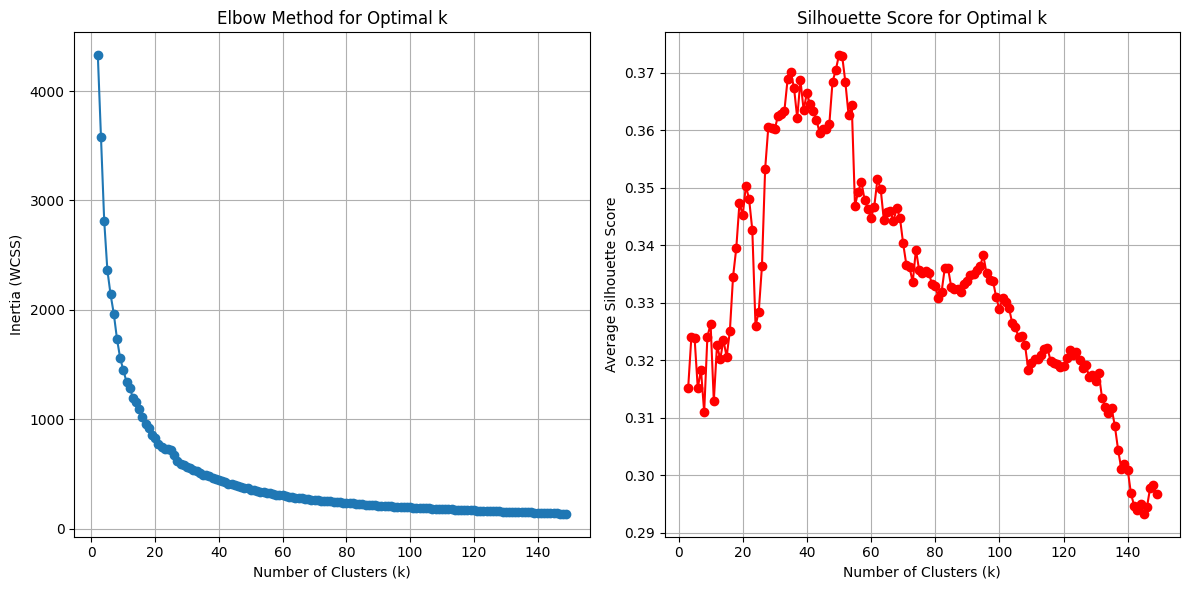


Optimal k by Silhouette Score: 50 (Score: 0.3731)
------------------------------


In [115]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score # Import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA # Import PCA
import umap # Import UMAP

# --- 1. Prepare All Normalized Embeddings ---
ref_embeddings_df = df.drop_duplicates(subset=['code']).set_index('code')
ref_embs_list = np.stack(ref_embeddings_df['ref_embeddings'].values)
ref_embs_norm = normalize(ref_embs_list)

# # --- 2. Perform Dimension Reduction using PCA ---
# # Choose the number of components.
# # You can choose a fixed number (e.g., 50, 100) or a fraction of variance to explain (e.g., 0.95 for 95%).
# n_components = 20 # Example: reduce to 50 dimensions. Adjust as needed.

# pca = PCA(n_components=n_components, random_state=42)

# # Fit PCA ONLY on the Reference embeddings (gold standard)
# pca.fit(ref_embs_norm)

# # Transform all sets of embeddings using the fitted PCA model
# ref_embs_reduced = pca.transform(ref_embs_norm)
# all_bench_embs_reduced = pca.transform(all_bench_embs_norm)
# all_pers_embs_reduced = pca.transform(all_pers_embs_norm)

# print(f"PCA fitted, capturing {pca.explained_variance_ratio_.sum():.2%} of variance.")
# print(f"Shape of Reduced Ref embeddings: {ref_embs_reduced.shape}")
# print(f"Shape of Reduced ALL Benchmark embeddings: {all_bench_embs_reduced.shape}")
# print(f"Shape of Reduced ALL Persona embeddings: {all_pers_embs_reduced.shape}")
# print("-" * 30)

# --- 2. Perform Dimension Reduction using UMAP ---
# Choose the number of components.
# Common values for visualization are 2 or 3. For clustering, you might go higher (e.g., 10, 20, 50).
n_components = 30 # Example: reduce to 50 dimensions. Adjust as needed.

# UMAP specific parameters:
# n_neighbors: Controls how UMAP balances local vs. global structure.
#    Smaller values emphasize local structure, larger values emphasize global structure.
#    Common values are 15-200. Default is 15.
# min_dist: Controls how tightly points are allowed to pack together.
#    Smaller values mean tighter clusters. Default is 0.1.
# metric: The distance metric to use. 'cosine' is good for normalized embeddings.
reducer = umap.UMAP(n_components=n_components,
                     n_neighbors=15, # Tune this
                     min_dist=0.5,   # Tune this
                     metric='cosine', # Or 'euclidean' if preferred, but cosine is good for normalized vecs
                     random_state=42)

# Fit UMAP ONLY on the Reference embeddings (gold standard)
print("Fitting UMAP on Reference embeddings...")
reducer.fit(ref_embs_norm)
print("UMAP fitting complete.")

# Transform all sets of embeddings using the fitted UMAP model
ref_embs_reduced = reducer.transform(ref_embs_norm)
all_bench_embs_reduced = reducer.transform(all_bench_embs_norm)
all_pers_embs_reduced = reducer.transform(all_pers_embs_norm)

print(f"Shape of UMAP-reduced Ref embeddings: {ref_embs_reduced.shape}")
print(f"Shape of UMAP-reduced ALL Benchmark embeddings: {all_bench_embs_reduced.shape}")
print(f"Shape of UMAP-reduced ALL Persona embeddings: {all_pers_embs_reduced.shape}")
print("-" * 30)


# --- Find Optimal k for Reference Embeddings ---
print("Finding optimal k for Reference Embeddings...")

# Define a range of k values to test
# Start from 2, as silhouette score requires at least 2 clusters.
# The upper limit can be adjusted based on your data size and computational resources.
# For 879 jobs, you might try up to 200 or 300, but start smaller for testing.
k_range = range(2, min(300, 150)) # Test up to num_jobs or a reasonable upper bound

inertia_values = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(ref_embs_reduced)
    
    # Store inertia (WCSS)
    inertia_values.append(kmeans.inertia_)
    
    # Calculate Silhouette Score (only if k > 1)
    if k > 1:
        score = silhouette_score(ref_embs_reduced, kmeans.labels_)
        silhouette_scores.append(score)
    else:
        silhouette_scores.append(np.nan) # Placeholder for k=1, where silhouette is undefined

# --- Plotting Elbow Method ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)

# --- Plotting Silhouette Scores ---
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
# Adjust k_range for silhouette scores since it starts from k=2
plt.plot(list(k_range)[1:], silhouette_scores[1:], marker='o', color='red') 
plt.title('Silhouette Score for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Find k with highest Silhouette Score (excluding NaN for k=1)
if len(silhouette_scores) > 1:
    best_k_silhouette = k_range[np.nanargmax(silhouette_scores)]
    print(f"\nOptimal k by Silhouette Score: {best_k_silhouette} (Score: {np.nanmax(silhouette_scores):.4f})")
else:
    print("\nNot enough k values to calculate meaningful Silhouette Scores.")

print("-" * 30)


Fitting UMAP on Reference embeddings for 2D plot (n_components=2)...


c:\Users\godfr\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP fitting complete for plot.
Shape of 2D UMAP-reduced Ref embeddings: (879, 2)
------------------------------
Clustering performed for visualization with k=50.
------------------------------
Length of true_labels_bench_plot: 35160
Length of predicted_labels_bench_plot: 8790
Length of true_labels_pers_plot: 35160
Length of predicted_labels_pers_plot: 8790
------------------------------


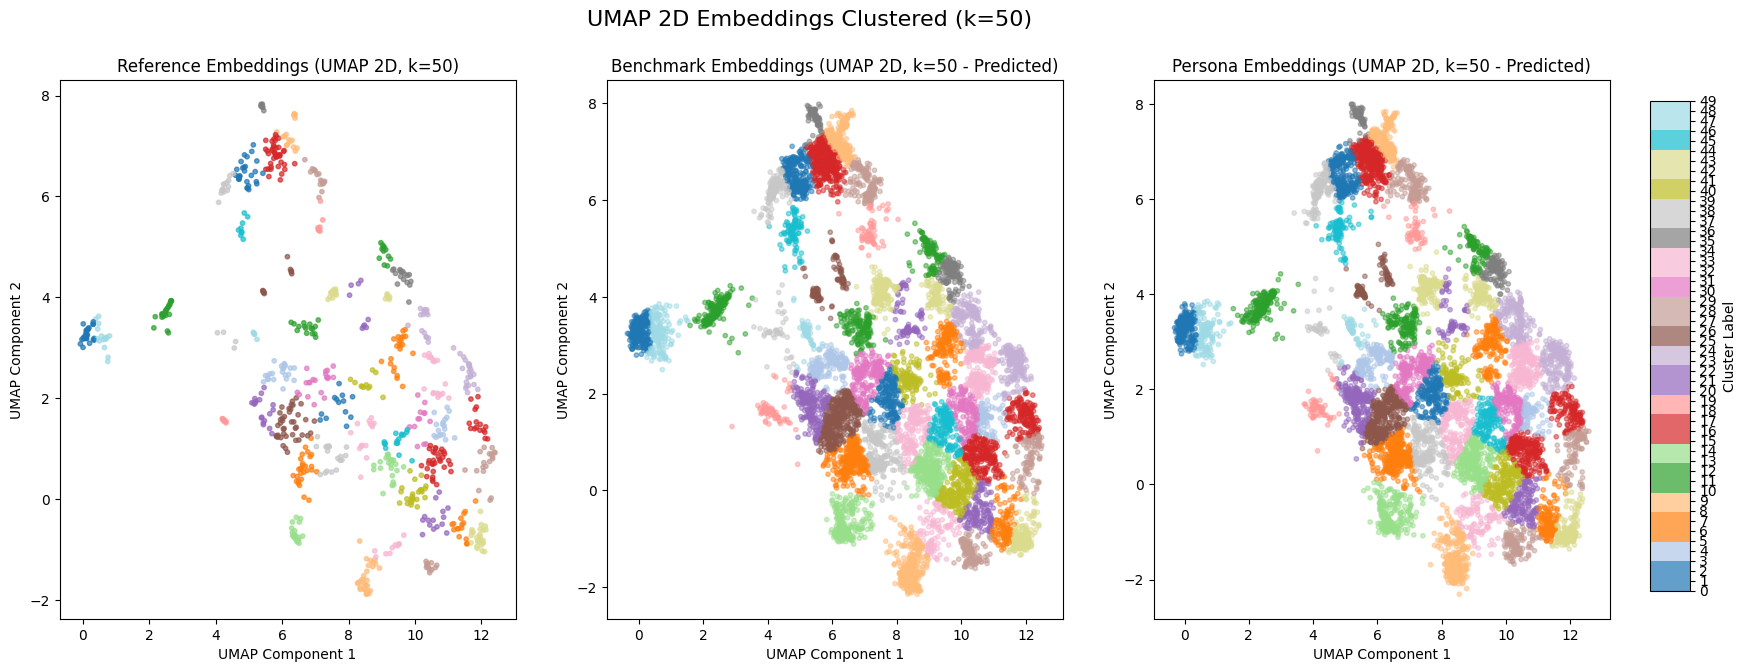


2D UMAP plots generated. Observe how well Benchmark and Persona embeddings align with the Reference clusters.
The tighter and more distinct the groups in the Benchmark/Persona plots, the better the semantic structure is preserved.
------------------------------


ValueError: Found input variables with inconsistent numbers of samples: [35160, 8790]

In [119]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot # For colormaps

# --- 2. Perform Dimension Reduction using UMAP (n_components=2 for plotting) ---
n_components_plot = 2 # Set to 2 for visualization

reducer_plot = umap.UMAP(n_components=n_components_plot,
                         n_neighbors=15, # You can tune this
                         min_dist=0.1,   # You can tune this
                         metric='cosine',
                         random_state=42)

print(f"Fitting UMAP on Reference embeddings for 2D plot (n_components={n_components_plot})...")
reducer_plot.fit(ref_embs_norm)
print("UMAP fitting complete for plot.")

ref_embs_reduced_plot = reducer_plot.transform(ref_embs_norm)
all_bench_embs_reduced_plot = reducer_plot.transform(all_bench_embs_norm)
all_pers_embs_reduced_plot = reducer_plot.transform(all_pers_embs_norm)

print(f"Shape of 2D UMAP-reduced Ref embeddings: {ref_embs_reduced_plot.shape}")
print("-" * 30)


# --- 3. Find Optimal k (using the *same* process as before, for consistency) ---
# Note: This part uses the potentially higher-dimensional UMAP embeddings for k optimization
# if you set n_components higher than 2 in the previous tuning step.
# For plot, we'll use n_components_plot=2.

# You should still run the Elbow/Silhouette for your chosen higher `n_components`
# (e.g., n_components = 50 from previous step) to determine the best `k_clusters`.
# For demonstration purposes, we'll use a fixed k_clusters here or the one identified previously.
k_clusters = 50 # Example: Use the k you found to be optimal (e.g., from silhouette score)

# --- 4. Define Reference Clusters (Gold Standard) ---
# Use the *2D reduced reference embeddings* for KMeans fitting for the purpose of this plot.
# This ensures the cluster labels align with what you see on the 2D plot.
# If your final clustering is done on higher dimensions, these labels might vary slightly,
# but for visualization, 2D K-Means is often good enough to show the groups.
kmeans_ref_plot = KMeans(n_clusters=k_clusters, random_state=42, n_init='auto')
kmeans_ref_plot.fit(ref_embs_reduced_plot)
ref_cluster_labels_plot = kmeans_ref_plot.labels_


# --- 5. Map Job Codes to Reference Clusters (for ground truth labels) ---
code_to_ref_cluster = {}
for i, code in enumerate(ref_embeddings_df.index):
    code_to_ref_cluster[code] = ref_cluster_labels_plot[i]


# --- 6. Create "Ground Truth" Labels for Generated Data (for plotting consistency) ---
true_labels_bench_plot = []
for code in df[df['prompt'] == 'benchmark']['code']:
    true_labels_bench_plot.append(code_to_ref_cluster[code])

true_labels_pers_plot = []
for code in df[df['prompt'] == 'persona']['code']:
    true_labels_pers_plot.append(code_to_ref_cluster[code])

true_labels_bench_plot = np.array(true_labels_bench_plot)
true_labels_pers_plot = np.array(true_labels_pers_plot)



# --- 7. Predict Clusters for Generated Data (using Reference KMeans Model, 2D) ---
predicted_labels_bench_plot = kmeans_ref_plot.predict(all_bench_embs_reduced_plot) 
predicted_labels_pers_plot = kmeans_ref_plot.predict(all_pers_embs_reduced_plot)

print(f"Clustering performed for visualization with k={k_clusters}.")
print("-" * 30)

# --- 6. Create "Ground Truth" Labels for Generated Data (for plotting consistency) ---
# Ensure the codes are extracted directly from the DataFrame slices
# that correspond to the generated embeddings, to guarantee length alignment.

# Get the codes for the exact rows that correspond to all_bench_embs_reduced_plot
job_codes_for_bench_embeddings = df[df['prompt'] == 'benchmark']['code'].values
true_labels_bench_plot = np.array([code_to_ref_cluster[jc] for jc in job_codes_for_bench_embeddings])

# Get the codes for the exact rows that correspond to all_pers_embs_reduced_plot
job_codes_for_pers_embeddings = df[df['prompt'] == 'persona']['code'].values
true_labels_pers_plot = np.array([code_to_ref_cluster[jc] for jc in job_codes_for_pers_embeddings])

print(f"Length of true_labels_bench_plot: {len(true_labels_bench_plot)}")
print(f"Length of predicted_labels_bench_plot: {len(predicted_labels_bench_plot)}")
print(f"Length of true_labels_pers_plot: {len(true_labels_pers_plot)}")
print(f"Length of predicted_labels_pers_plot: {len(predicted_labels_pers_plot)}")
print("-" * 30)

# --- Plotting the 2D UMAP Embeddings and Clusters ---

# Create a color map for consistent coloring across plots
colors = pyplot.get_cmap('tab20', k_clusters) # 'tab20' is good for up to 20 clusters, choose a larger one if k > 20

fig, axes = plt.subplots(1, 3, figsize=(20, 7)) # 1 row, 3 columns for 3 plots

# Plot 1: Reference Embeddings with their assigned clusters
scatter_ref = axes[0].scatter(ref_embs_reduced_plot[:, 0], ref_embs_reduced_plot[:, 1],
                              c=ref_cluster_labels_plot, cmap=colors, s=10, alpha=0.7)
axes[0].set_title(f'Reference Embeddings (UMAP 2D, k={k_clusters})')
axes[0].set_xlabel('UMAP Component 1')
axes[0].set_ylabel('UMAP Component 2')
# Add centroids (optional)
# axes[0].scatter(kmeans_ref_plot.cluster_centers_[:, 0], kmeans_ref_plot.cluster_centers_[:, 1],
#                marker='X', s=200, color='black', label='Centroids')
# axes[0].legend()


# Plot 2: Benchmark Embeddings predicted into Reference clusters
scatter_bench = axes[1].scatter(all_bench_embs_reduced_plot[:, 0], all_bench_embs_reduced_plot[:, 1],
                                c=predicted_labels_bench_plot, cmap=colors, s=10, alpha=0.5)
axes[1].set_title(f'Benchmark Embeddings (UMAP 2D, k={k_clusters} - Predicted)')
axes[1].set_xlabel('UMAP Component 1')
axes[1].set_ylabel('UMAP Component 2')


# Plot 3: Persona Embeddings predicted into Reference clusters
scatter_pers = axes[2].scatter(all_pers_embs_reduced_plot[:, 0], all_pers_embs_reduced_plot[:, 1],
                               c=predicted_labels_pers_plot, cmap=colors, s=10, alpha=0.5)
axes[2].set_title(f'Persona Embeddings (UMAP 2D, k={k_clusters} - Predicted)')
axes[2].set_xlabel('UMAP Component 1')
axes[2].set_ylabel('UMAP Component 2')


# Add a single colorbar for all plots (optional, but good for consistent color mapping)
# You might want to adjust its position
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # x, y, width, height
cbar = fig.colorbar(scatter_ref, cax=cbar_ax, ticks=np.linspace(0, k_clusters-1, k_clusters))
cbar.set_label('Cluster Label')

plt.suptitle(f'UMAP 2D Embeddings Clustered (k={k_clusters})', fontsize=16)
plt.show()

print("\n2D UMAP plots generated. Observe how well Benchmark and Persona embeddings align with the Reference clusters.")
print("The tighter and more distinct the groups in the Benchmark/Persona plots, the better the semantic structure is preserved.")
print("-" * 30)

# --- Optional: Recalculate ARI with these 2D clusters for direct comparison to plot ---
# This ARI will likely be lower than if you used higher n_components for clustering,
# but it directly corresponds to what you see in the 2D plot.
ari_bench_plot = adjusted_rand_score(true_labels_bench_plot, predicted_labels_bench_plot)
ari_pers_plot = adjusted_rand_score(true_labels_pers_plot, predicted_labels_pers_plot)

print(f"ARI (2D UMAP, k={k_clusters}) - Benchmark: {ari_bench_plot:.4f}")
print(f"ARI (2D UMAP, k={k_clusters}) - Persona: {ari_pers_plot:.4f}")
print("Note: These ARIs are based on the 2D reduction for plotting. Your primary ARI results should use the higher-dimensional UMAP reduction if you found that to be better for clustering.")